# Dataset

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from sklearn.model_selection import train_test_split

In [35]:
# import of emissions data for EU countries
df_europe = pd.read_csv('final_df_UE.csv')
df_europe.head()

,Country,Sector,Gas,year,cons
0,Austria,Agriculture,All GHG,2019,7.21
1,Austria,Agriculture,CH4,2019,4.64
2,Austria,Agriculture,N2O,2019,2.57
3,Austria,Building,All GHG,2019,8.41
4,Austria,Building,CO2,2019,7.73


In [36]:
# creation of timeseries CO2 emissions of France transportation sector
transport_co2 = df_europe[(df_europe['Country']== 'France') &
                          (df_europe['Sector']== 'Transportation')&
                          (df_europe['Gas']== 'CO2')]

transport_co2.index= pd.to_datetime(transport_co2['year'], format='%Y')

transport_co2.drop(['Country', 'Sector', 'Gas', 'year'], axis = 1, inplace = True)
transport_co2 = transport_co2.sort_index()

In [37]:
transport_co2

,cons
year,
1990-01-01,113.23
1991-01-01,116.85
1992-01-01,119.36
1993-01-01,120.48
1994-01-01,121.38
1995-01-01,122.32
1996-01-01,122.12
1997-01-01,124.64
1998-01-01,129.12


# Exploration 

## Trend and seasonality

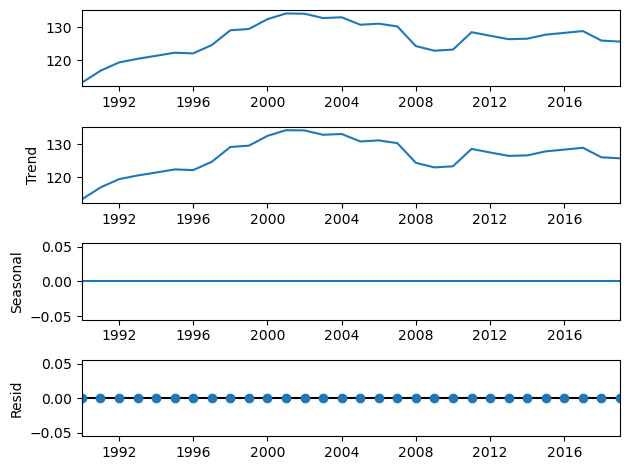

In [38]:
#seasonal decompose - additive model
result = seasonal_decompose(transport_co2)
result.plot()
plt.show();

## Stationarity

P-value Dickey-Fuller test: 0.0456
The series is stationary


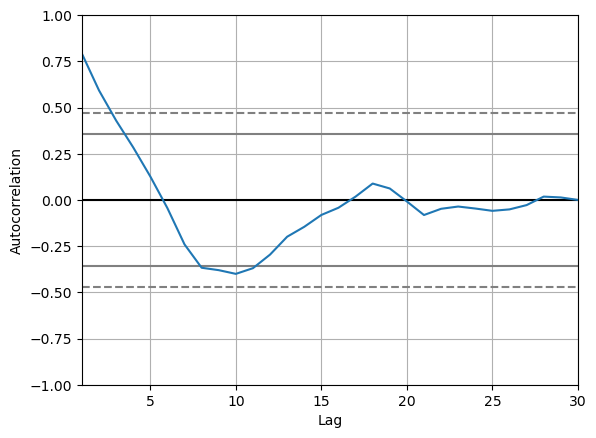

In [39]:
# checking the series stationarity

_, p_value, _, _, _, _ = sm.tsa.stattools.adfuller(transport_co2)
print('P-value Dickey-Fuller test:',round(p_value, 4))
print('The series is stationary' if p_value < 0.05 else 'The series is not stationary')

autocorrelation_plot(transport_co2);

P-value Dickey-Fuller test: 0.0011
The series is stationary


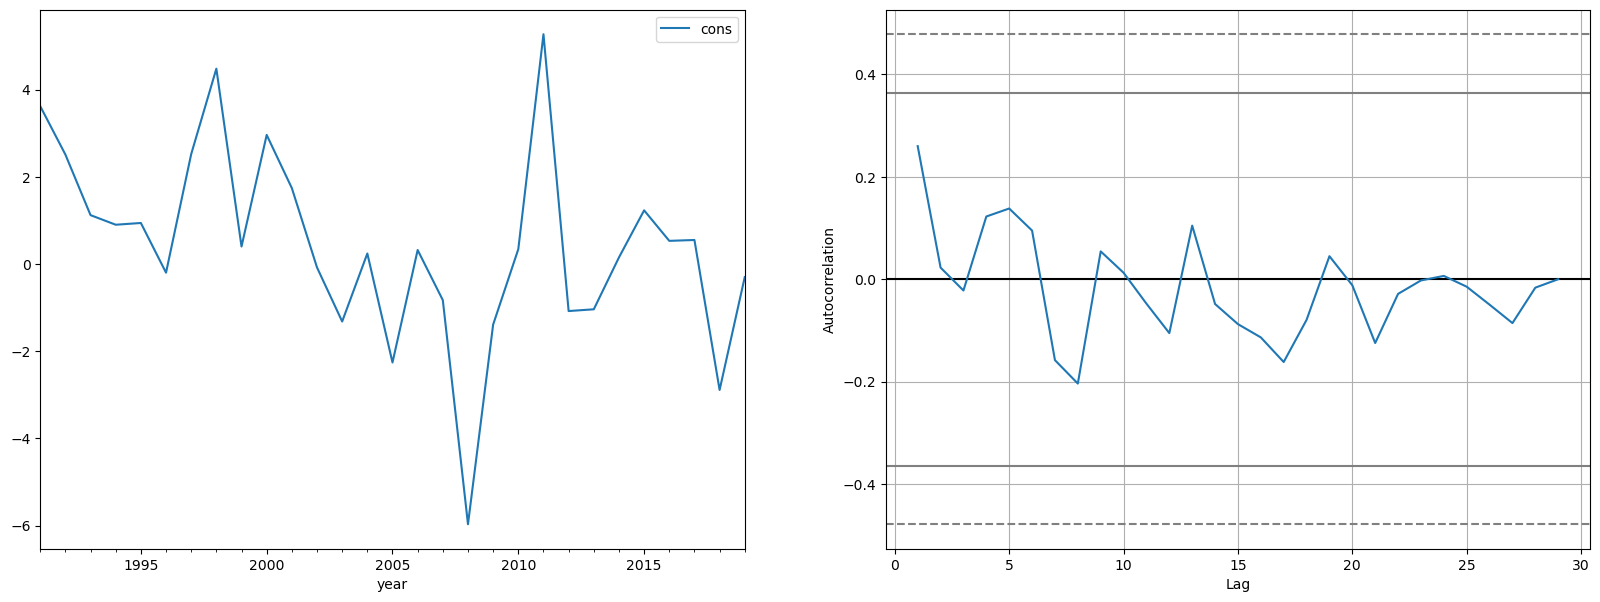

In [40]:
# simple differentiation

transport_1 =  transport_co2.diff(1).dropna()

_, p_value, _, _, _, _ = sm.tsa.stattools.adfuller(transport_1)
print('P-value Dickey-Fuller test:',round(p_value, 4))
print('The series is stationary' if p_value < 0.05 else 'The series is not stationary')

fig, (ax1,ax2) = plt.subplots(1,2, figsize = (20,7))
transport_1.plot(ax = ax1)

autocorrelation_plot(transport_1, ax = ax2);

# Modelization

## Performance metrics

In [41]:
# creation of a function to calculate performance metrics

def calculate_scores(y_true,y_pred):
    print("MAE:", mean_absolute_error(y_true,y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("MAPE:", mean_absolute_percentage_error(y_true, y_pred))
    print("r2", r2_score(y_true,y_pred))


## Statistical models

### ARIMA

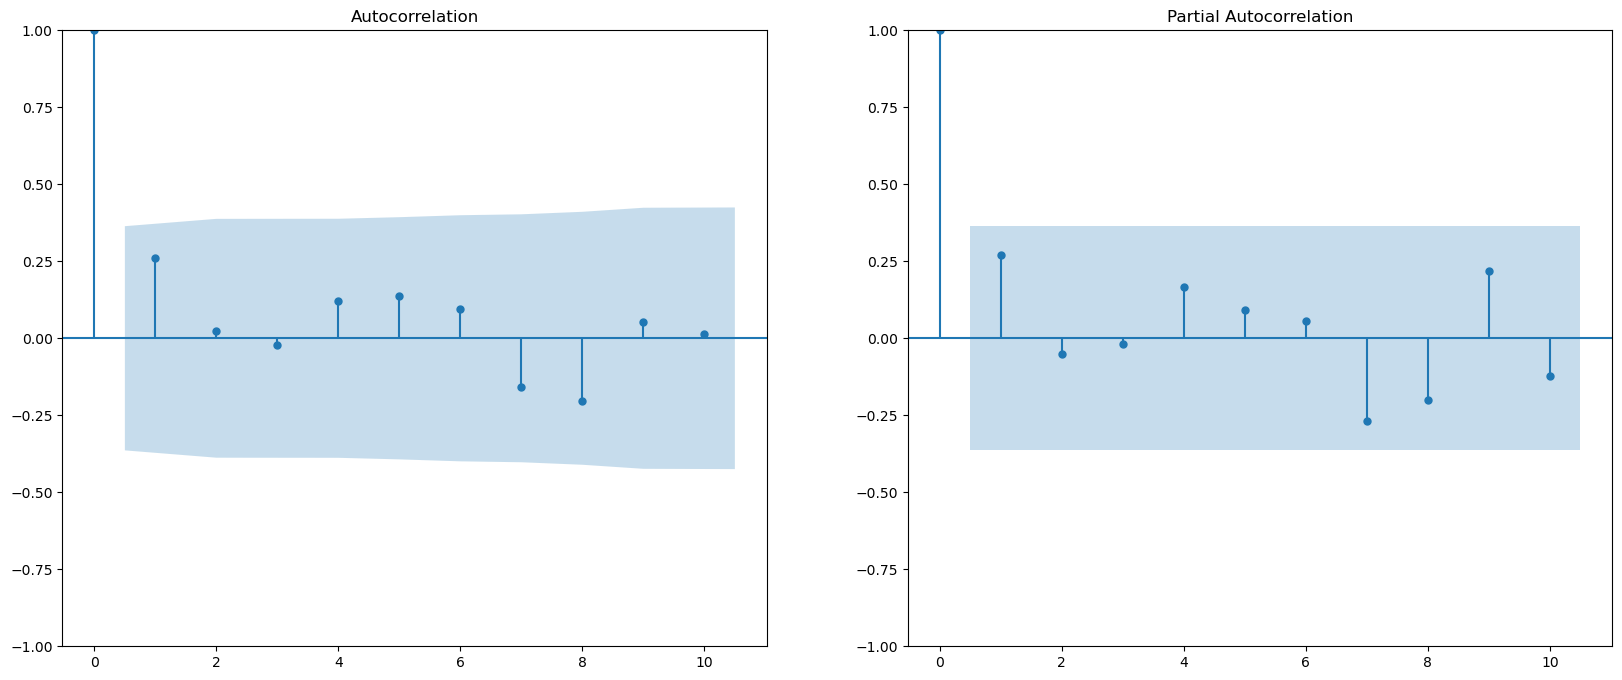

In [42]:
# autocorrelation plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,8))
plot_acf(transport_1, lags = 10, ax = ax1)
plot_pacf(transport_1, lags = 10, ax = ax2)
plt.show();

In [43]:
# creation of training and test datasets

train, test = train_test_split(transport_co2, test_size = 0.2, shuffle = False)
train

,cons
year,
1990-01-01,113.23
1991-01-01,116.85
1992-01-01,119.36
1993-01-01,120.48
1994-01-01,121.38
1995-01-01,122.32
1996-01-01,122.12
1997-01-01,124.64
1998-01-01,129.12


In [44]:
# Finding best parameters for ARIMA model

p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)

best_score = float("inf")
best_params = (0,0,0)

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            warnings.filterwarnings("ignore")
            model = sm.tsa.arima.ARIMA(train, order=order).fit()
            predictions = model.predict(start=len(train), end=len(train) + len(test)-1)
            error = mean_absolute_error(test, predictions)
            if error < best_score:
                best_score = error
                best_params = order

print('Best ARIMA%s MAE=%.3f' % (best_params, best_score))

Best ARIMA(4, 0, 5) MAE=0.797


In [12]:
# training best ARIMA model

arima = sm.tsa.arima.ARIMA(train, order=(4, 0, 5))
arima_fitted = arima.fit()

arima_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   cons   No. Observations:                   24
Model:                 ARIMA(4, 0, 5)   Log Likelihood                 -53.479
Date:                Tue, 06 Dec 2022   AIC                            128.958
Time:                        14:55:29   BIC                            141.916
Sample:                    01-01-1990   HQIC                           132.395
                         - 01-01-2013                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        125.4125      5.053     24.820      0.000     115.509     135.316
ar.L1          1.1689      0.862      1.355      0.175      -0.521       2.859
ar.L2         -0.1291      2.333     -0.055      0.956      -4.703       4.444
ar.L3         -0.5245      2.639     -0.199      0.842      -5.697       4.648
ar.L4          0.3283      1.365      0.241      0.810      -2.347       3.004
ma.L1          0.0760     40.930      0.002      0.999     -80.145      80.297
ma.L2         -0.2679     38.058     -0.007      0.994     -74.860      74.324
ma.L3          0.5756     26.891      0.021      0.983     -52.129      53.280
ma.L4          0.2795      3.545      0.079      0.937      -6.668       7.228
ma.L5          0.3568     14.014      0.025      0.980     -27.110      27.824
sigma2         4.1095    165.681      0.025      0.980    -320.618     328.837
===================================================================================
Ljung-Box (L1) (Q):                   0.77   Jarque-Bera (JB):                 0.33
Prob(Q):                              0.38   Prob(JB):                         0.85
Heteroskedasticity (H):               1.48   Skew:                            -0.06
Prob(H) (two-sided):                  0.59   Kurtosis:                         2.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

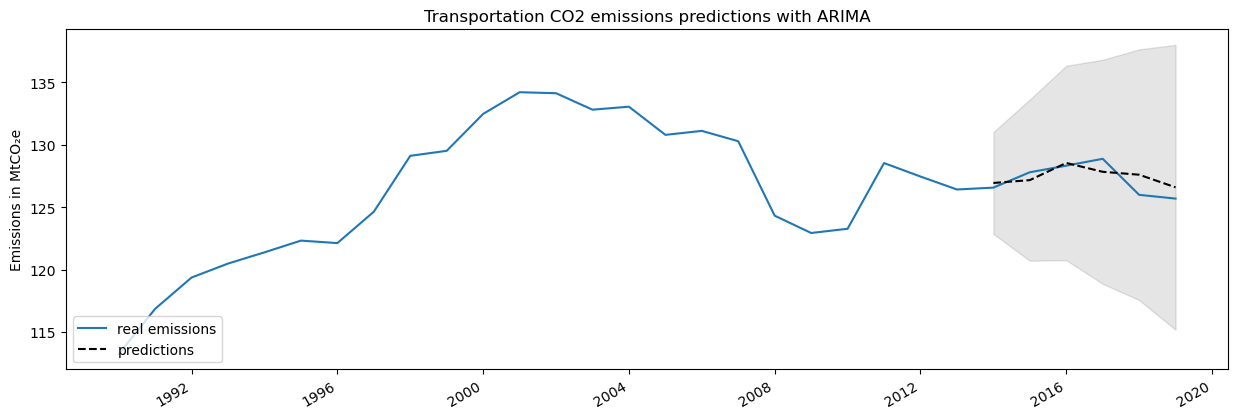

In [13]:
arima_pred = arima_fitted.get_forecast(steps =6).summary_frame() 

fig, ax = plt.subplots(figsize = (15,5))

plt.plot(transport_co2, label = 'real emissions')

arima_pred['mean'].plot(ax = ax, style = 'k--', label = 'predictions') 

ax.fill_between(arima_pred.index, arima_pred['mean_ci_lower'], arima_pred['mean_ci_upper'], color='k', alpha=0.1)
plt.title('Transportation CO2 emissions predictions with ARIMA')
plt.ylabel("Emissions in MtCO₂e")
plt.legend(loc = 'lower left');

In [15]:
# performance metrics ARIMA

calculate_scores(test,arima_pred['mean'])

MAE: 0.7965300132067105
RMSE: 0.9208652655048787
MAPE: 0.0062747830990002515
r2 0.40836333132396074


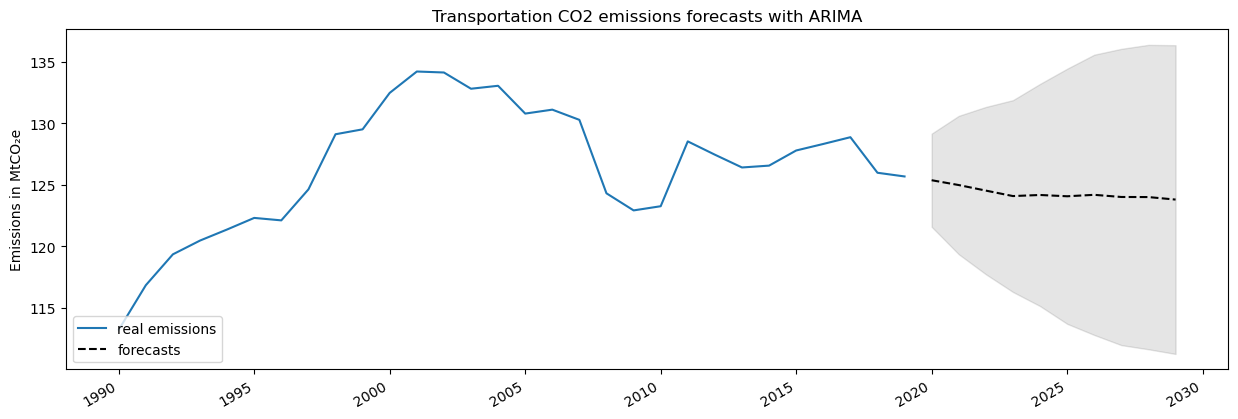

In [16]:
# training on full dataset then making forecasts 

arima = sm.tsa.arima.ARIMA(transport_co2, order=(4, 0, 5))
arima_fitted = arima.fit()

arima_forecasts = arima_fitted.get_forecast(steps =10).summary_frame() 

fig, ax = plt.subplots(figsize = (15,5))

plt.plot(transport_co2, label = 'real emissions')

arima_forecasts['mean'].plot(ax = ax, style = 'k--', label = 'forecasts') 

ax.fill_between(arima_forecasts.index, arima_forecasts['mean_ci_lower'], arima_forecasts['mean_ci_upper'], color='k', alpha=0.1)
plt.title('Transportation CO2 emissions forecasts with ARIMA')
plt.ylabel("Emissions in MtCO₂e")
plt.legend(loc = 'lower left');

### ARIMAX

In [18]:
#import of transportation data 
vehicles = pd.read_csv("vehicles.csv", sep = ";", index_col = 0, parse_dates = ['year'])
vehicles.head()

,tot_vehicles,tot_diesel_vehicles,tot_vehic_km,tot_diesel_vehic_km
year,,,,
1990-01-01,33227.84,6602.57,420.10,149.65
1991-01-01,33739.11,7359.41,433.00,165.21
1992-01-01,33800.00,8140.38,445.51,179.85
1993-01-01,33986.06,9092.45,454.03,194.16
1994-01-01,34664.53,9768.10,460.06,207.60


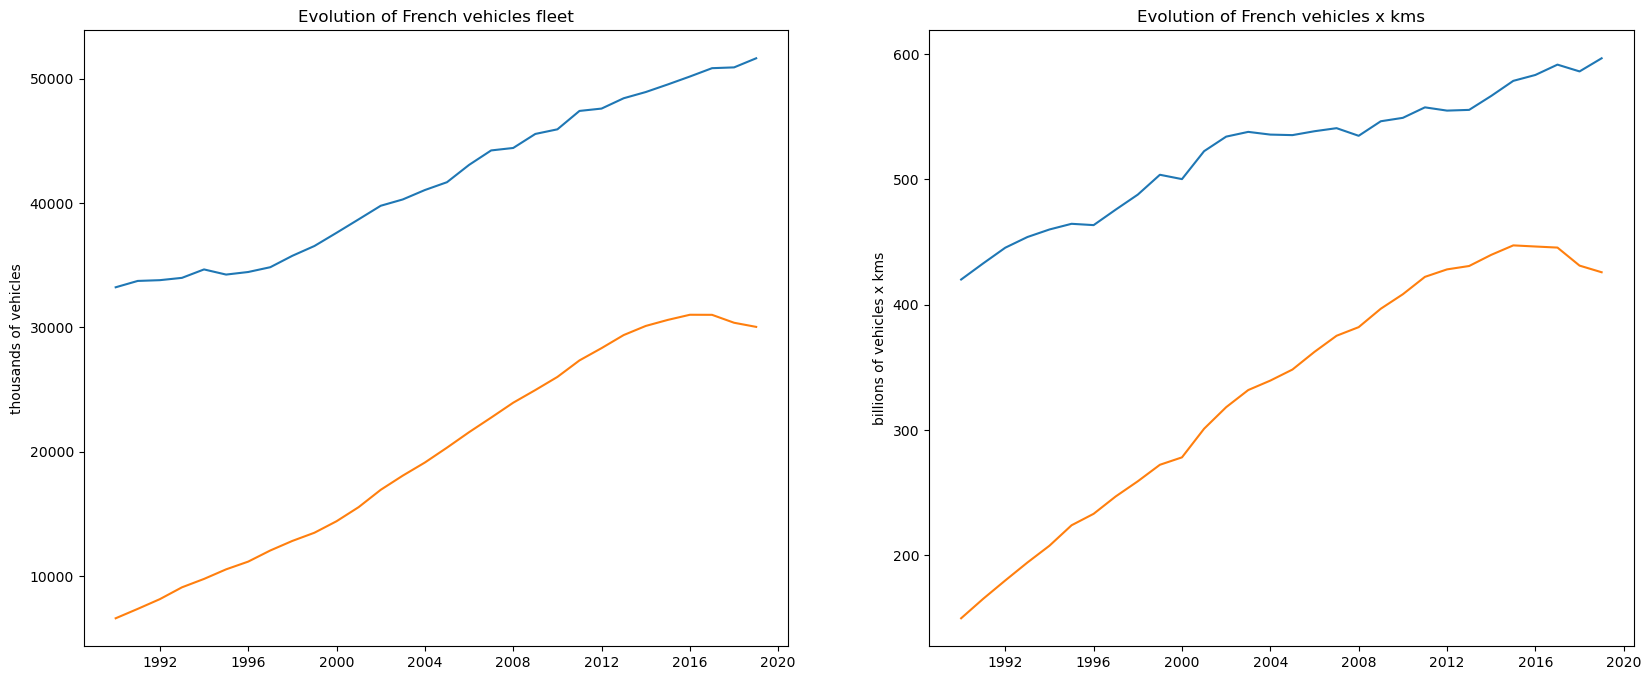

In [19]:
plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
plt.plot(vehicles['tot_vehicles'], label = 'total vehicles')
plt.plot(vehicles['tot_diesel_vehicles'], label = 'total diesel vehicles')
plt.ylabel('thousands of vehicles')
plt.title('Evolution of French vehicles fleet')                  

plt.subplot(1,2,2)
plt.plot(vehicles['tot_vehic_km'], label = 'total vehicles x kms')
plt.plot(vehicles['tot_diesel_vehic_km'], label = 'total diesel vehicles x kms')
plt.ylabel('billions of vehicles x kms')
plt.title('Evolution of French vehicles x kms') ;

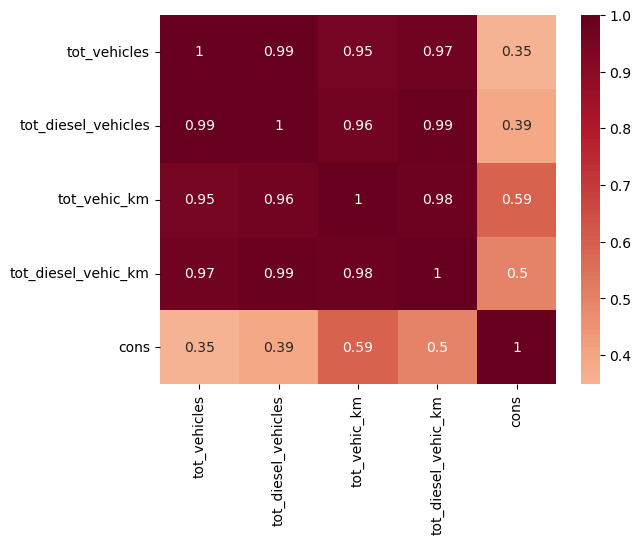

In [20]:
# correlation analysis
vehicles['cons'] = [i for i in transport_co2['cons']]

import seaborn as sns

sns.heatmap(vehicles[['tot_vehicles','tot_diesel_vehicles', 'tot_vehic_km','tot_diesel_vehic_km', 'cons']].corr(), annot = True, center =0, cmap = 'RdBu_r');

In [21]:
# creation of exog variable datasets

exog_train, exog_test = train_test_split(vehicles['tot_vehic_km'], test_size = 0.2, shuffle = False)


In [22]:
# Find best parameters for ARIMAX model
p_values = range(0, 6)
d_values = range(0, 3)
q_values = range(0, 6)

best_score = float("inf")
best_params = (0,0,0)

for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p,d,q)
            warnings.filterwarnings("ignore")
            model = sm.tsa.arima.ARIMA(train, exog = exog_train, order=order).fit()
            predictions = model.predict(start=len(train), end=len(train) + len(test)-1, exog = exog_test)
            error = mean_absolute_error(test, predictions)
            if error < best_score:
                best_score = error
                best_params = order

print('Best ARIMAX%s MAE=%.3f' % (best_params, best_score))

Best ARIMAX(0, 2, 4) MAE=0.629


In [23]:
# ARIMAX with tot_vehicles variable
arimax = sm.tsa.arima.ARIMA(train, exog = exog_train, order=(0, 2, 4))
arimax_fitted = arimax.fit()

arimax_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   cons   No. Observations:                   24
Model:                 ARIMA(0, 2, 4)   Log Likelihood                 -48.208
Date:                Tue, 06 Dec 2022   AIC                            108.415
Time:                        15:00:14   BIC                            114.961
Sample:                    01-01-1990   HQIC                           109.957
                         - 01-01-2013                                         
Covariance Type:                  opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
tot_vehic_km     0.1565      0.081      1.931      0.053      -0.002       0.315
ma.L1           -0.7820      0.401     -1.951      0.051      -1.567       0.003
ma.L2           -0.1024      0.355     -0.288      0.773      -0.799       0.594
ma.L3           -0.1172      0.292     -0.401      0.689      -0.690       0.456
ma.L4            0.1844      0.510      0.362      0.717      -0.815       1.183
sigma2           4.4035      1.487      2.962      0.003       1.490       7.317
===================================================================================
Ljung-Box (L1) (Q):                   0.17   Jarque-Bera (JB):                 0.96
Prob(Q):                              0.68   Prob(JB):                         0.62
Heteroskedasticity (H):               6.66   Skew:                             0.46
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

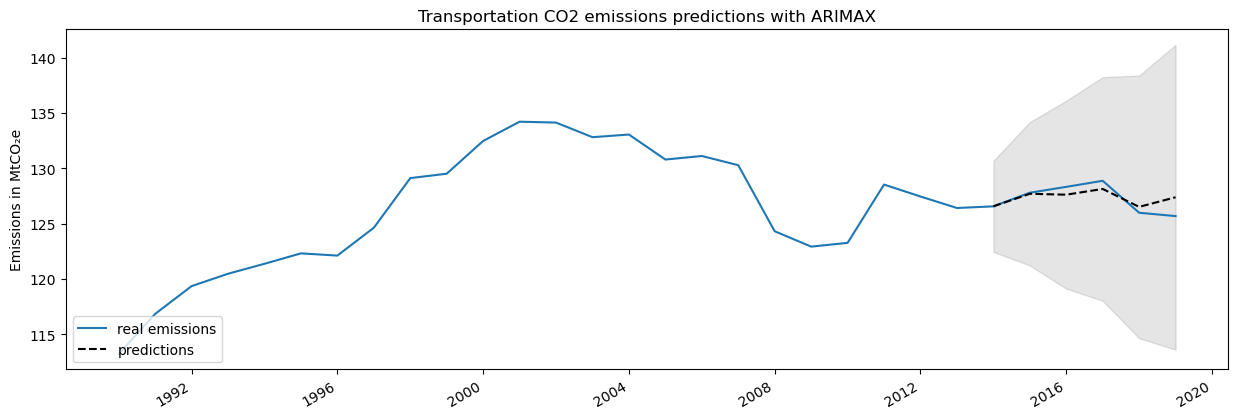

In [24]:
# ARIMAX representation  

arimax_pred = arimax_fitted.get_forecast(steps=6, exog = exog_test).summary_frame()
fig, ax = plt.subplots(figsize = (15,5))

plt.plot(transport_co2, label = 'real emissions')

arimax_pred['mean'].plot(ax = ax, style = 'k--', label = 'predictions')

ax.fill_between(arimax_pred.index, arimax_pred['mean_ci_lower'], arimax_pred['mean_ci_upper'], color='k', alpha=0.1)
plt.title('Transportation CO2 emissions predictions with ARIMAX')
plt.ylabel("Emissions in MtCO₂e")
plt.legend(loc = 'lower left');

In [25]:
# performance metrics ARIMAX

calculate_scores(test,arimax_pred['mean'])

MAE: 0.6288169755778554
RMSE: 0.8396547941981433
MAPE: 0.004955667143799597
r2 0.5081140211958953


In [26]:
# training on full dataset
arimax = sm.tsa.arima.ARIMA(transport_co2, exog = vehicles['tot_vehic_km'], order=(0, 2, 4))
arimax_fitted = arimax.fit()


In [27]:
_, p_value, _, _, _, _ = sm.tsa.stattools.adfuller(vehicles['tot_vehic_km'])
print('P-value Dickey-Fuller test:',round(p_value, 4))
print('The series is stationary' if p_value < 0.05 else 'The series is not stationary')

P-value Dickey-Fuller test: 0.3803
The series is not stationary


In [28]:
vehicles_1 = vehicles['tot_vehic_km'].diff(1).dropna()

_, p_value, _, _, _, _ = sm.tsa.stattools.adfuller(vehicles_1)
print('P-value Dickey-Fuller test:',round(p_value, 4))
print('The series is stationary' if p_value < 0.05 else 'The series is not stationary')


P-value Dickey-Fuller test: 0.0
The series is stationary


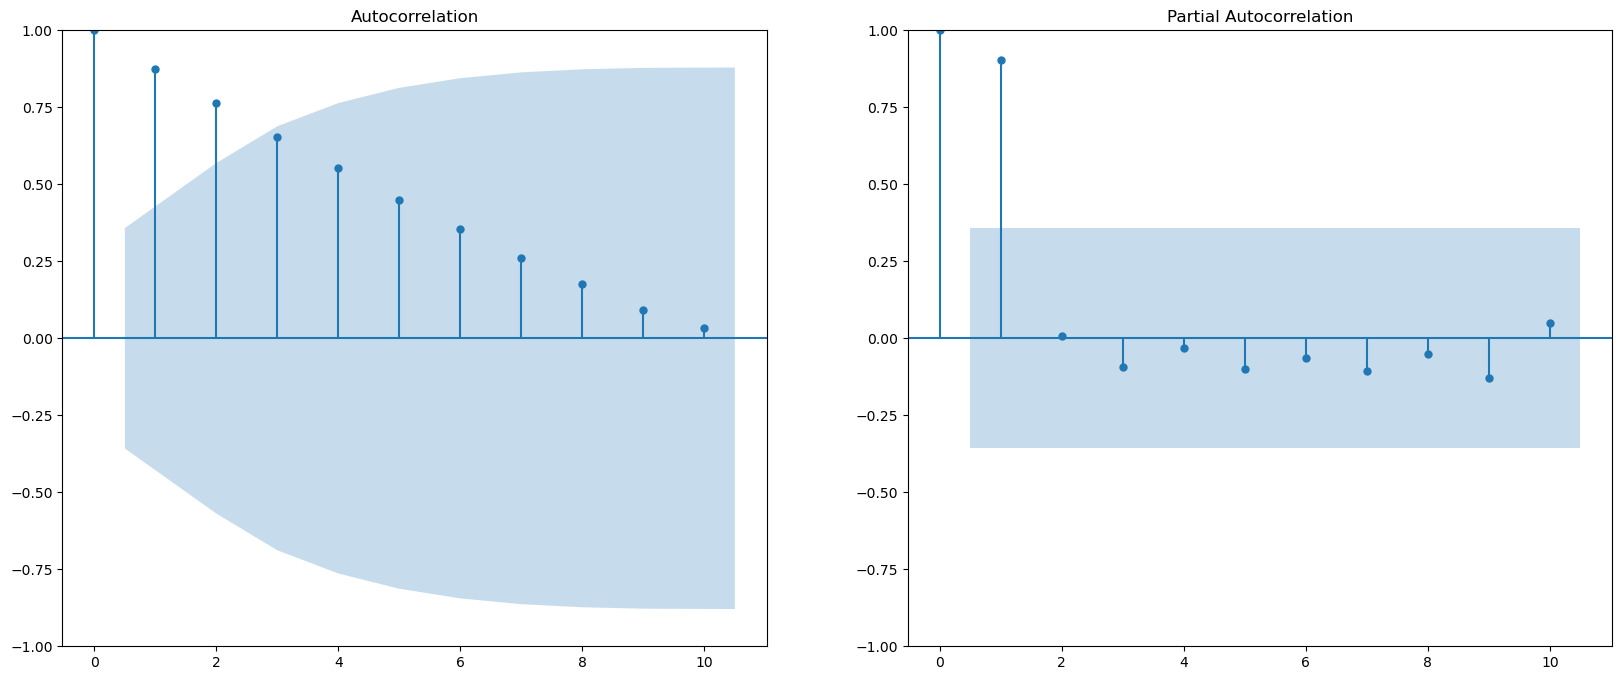

In [29]:
#forecast number of vehicles for the next 10 years

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,8))
plot_acf(vehicles['tot_vehic_km'], lags = 10, ax = ax1)
plot_pacf(vehicles['tot_vehic_km'], lags = 10, ax = ax2)
plt.show();

In [30]:
arima = sm.tsa.arima.ARIMA(vehicles['tot_vehic_km'], order=(1, 2, 0))
arima_fitted = arima.fit()

arima_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           tot_vehic_km   No. Observations:                   30
Model:                 ARIMA(1, 2, 0)   Log Likelihood                 -98.826
Date:                Tue, 06 Dec 2022   AIC                            201.651
Time:                        15:00:55   BIC                            204.315
Sample:                    01-01-1990   HQIC                           202.466
                         - 01-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5704      0.172     -3.309      0.001      -0.908      -0.233
sigma2        67.1577     24.343      2.759      0.006      19.446     114.869
===================================================================================
Ljung-Box (L1) (Q):                   0.53   Jarque-Bera (JB):                 0.62
Prob(Q):                              0.47   Prob(JB):                         0.73
Heteroskedasticity (H):               0.94   Skew:                            -0.01
Prob(H) (two-sided):                  0.92   Kurtosis:                         2.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

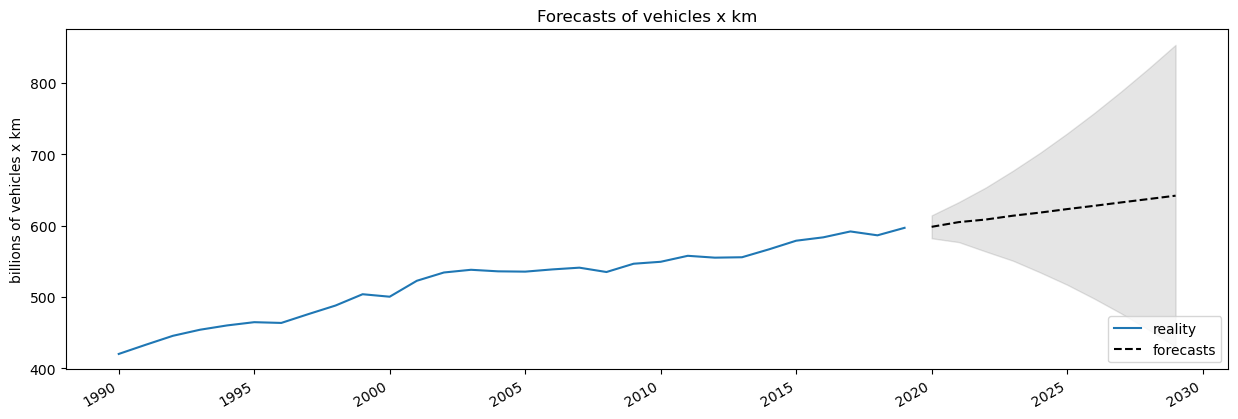

In [31]:
vehic_forecasts = arima_fitted.get_forecast(steps=10).summary_frame()

fig, ax = plt.subplots(figsize = (15,5))

plt.plot(vehicles['tot_vehic_km'], label = 'reality')

vehic_forecasts['mean'].plot(ax = ax, style = 'k--', label = 'forecasts')

ax.fill_between(vehic_forecasts.index, vehic_forecasts['mean_ci_lower'], vehic_forecasts['mean_ci_upper'], color='k', alpha=0.1)

plt.title('Forecasts of vehicles x km')
plt.ylabel("billions of vehicles x km")
plt.legend(loc = 'lower right');

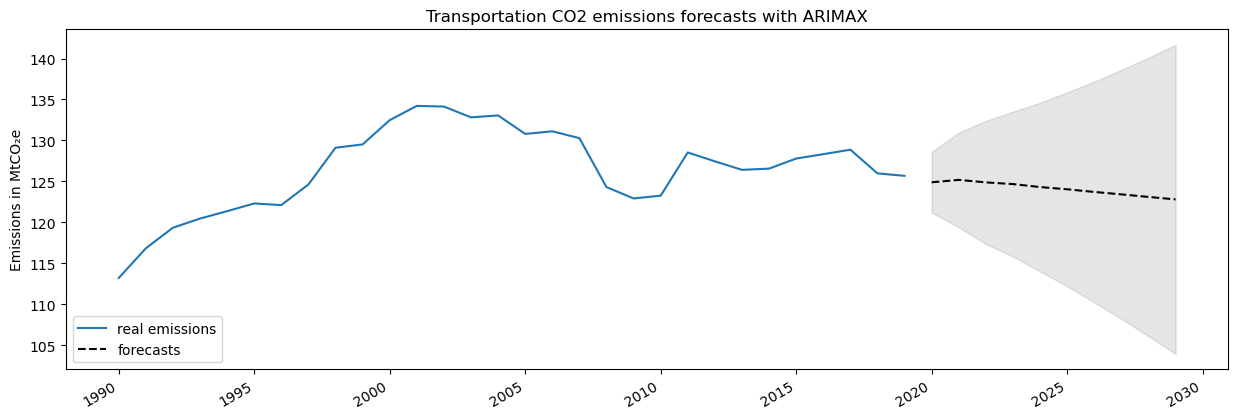

In [32]:
arimax_forecasts = arimax_fitted.get_forecast(steps=10, exog = vehic_forecasts['mean']).summary_frame()
fig, ax = plt.subplots(figsize = (15,5))

plt.plot(transport_co2, label = 'real emissions')

arimax_forecasts['mean'].plot(ax = ax, style = 'k--', label = 'forecasts')

ax.fill_between(arimax_forecasts.index, arimax_forecasts['mean_ci_lower'], arimax_forecasts['mean_ci_upper'], color='k', alpha=0.1)
plt.title('Transportation CO2 emissions forecasts with ARIMAX')
plt.ylabel("Emissions in MtCO₂e")
plt.legend(loc = 'lower left');